In [76]:
import pandas as pd
from time import time
import numpy as np
from tqdm import tqdm
import os
import netCDF4 as nc
from progressbar import progressbar
from astropy.convolution import convolve
from astropy.convolution import Gaussian2DKernel
import datetime
from matplotlib import pyplot as plt, rcParams
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib
from scipy.ndimage import gaussian_filter
from scipy.interpolate import LinearNDInterpolator
from regions import RectanglePixelRegion, PixCoord

from matplotlib import pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
import numpy as np
from matplotlib.patches import Rectangle
from random import random
from matplotlib.lines import Line2D
import pandas as pd
from time import time
import numpy as np
from tqdm import tqdm
import os
import netCDF4 as nc
from progressbar import progressbar
from astropy.convolution import convolve
from astropy.convolution import Gaussian2DKernel
import datetime
from matplotlib import pyplot as plt, rcParams
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib
from scipy.ndimage import gaussian_filter
import xarray as xr
import random
from scipy.interpolate import LinearNDInterpolator
from itertools import product
from scipy.signal import savgol_filter
tqdm.pandas()

from matplotlib import pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
import numpy as np
from matplotlib.patches import Rectangle
from random import random

%matplotlib inline

flooded_area = {'north': 28.1, 'south': 26.6, 'west': 58.9, 'east': 60.7}
iran = {'north': 31, 'south': 26, 'west': 59, 'east': 64}


In [6]:
# Helper functions CYGNSS

def filter_cygnss_df(df: pd.DataFrame, area: dict) -> pd.DataFrame:
    """
    Filters cygnss dataframe
    :param df: pd.Dataframe
    :param area: [N, W, S, E]
    :return: pd.Dataframe
    """
    if 'sp_lat' in df.columns:
        new_df = df[df['sp_lat'] <= area['north']]
        new_df = new_df[new_df['sp_lat'] >= area['south']]
        new_df = new_df[new_df['sp_lon'] >= area['west']]
        new_df = new_df[new_df['sp_lon'] <= area['east']]
    else:
        new_df = df[df['lat'] <= area['north']]
        new_df = new_df[new_df['lat'] >= area['south']]
        new_df = new_df[new_df['long'] >= area['west']]
        new_df = new_df[new_df['long'] <= area['east']]

    return new_df


def calculate_sr_value(snr, p_r, g_t, g_r, d_ts, d_sr):
    return snr - p_r - g_t - g_r - (20 * np.log10(0.19)) + (20 * np.log10(d_ts + d_sr)) + (20 * np.log10(4 * np.pi))


def compute_surface_reflectivity(df):
    df['sr'] = df.apply(
        lambda row: calculate_sr_value(row.ddm_snr, row.gps_tx_power_db_w, row.gps_ant_gain_db_i, row.sp_rx_gain,
                                       row.tx_to_sp_range, row.rx_to_sp_range), axis=1)
    return df


def compute_hours_after_jan(df):
    df['hours_after_jan_2020'] = df.apply(
        lambda row: calculate_hours_after_jan_value(row.day_of_year, row.ddm_timestamp_utc), axis=1)
    return df


def calculate_hours_after_jan_value(day_of_year, ddm_timestamp):
    return (day_of_year - 1) * 24 + ddm_timestamp / (60 * 60)


def filter_inc_angle(df: pd.DataFrame, angles: list):
    df = df[df['sp_inc_angle'] >= angles[0]]
    df = df[df['sp_inc_angle'] <= angles[1]]
    return df

def get_cygnss_df(root_path: str, days: list, month: int, area: dict, inc_angle_interval: list) -> pd.DataFrame:
    if month < 10:
        file_start = '/raw_main_df_2020_0' + str(month) + '_'
    else:
        file_start = '/raw_main_df_2020_' + str(month) + '_'
            
    file_ending = 'of31.csv'
    
    df = pd.DataFrame()
    
    for day in tqdm(days):
        current_path = root_path + file_start + str(day) + file_ending
        current_cygnss_df = compute_surface_reflectivity(filter_cygnss_df(pd.read_csv(current_path), area))
        current_cygnss_df = filter_inc_angle(current_cygnss_df, inc_angle_interval)
        current_cygnss_df = compute_hours_after_jan(current_cygnss_df)
        df = df.append(current_cygnss_df)
    
    
    return df.rename(columns={'sp_lat': 'lat', 'sp_lon': 'long'})


def filter_quality_flags_1(filter_df, use_print=True):
    if use_print:
        print('Removing bad quality CYGNSS measurements...')
    rows_before_removal = filter_df.shape[0]
    filter_df['qf_ok'] = filter_df.apply(
        lambda row: (2 or 4 or 5 or 8 or 16 or 17) not in generate_qf_list(int(row.quality_flags)), axis=1)
    filter_df = filter_df[filter_df['qf_ok']]
    rows_after_removal = filter_df.shape[0]
    
    if use_print:
        print('Removed ' + str(rows_before_removal - rows_after_removal) + ' rows of bad overall quality')
    
    return filter_df


def generate_qf_list(qf_number):
    qf_list = []
    binary = format(qf_number, 'b')
    for i in range(len(binary)):
        if binary[i] == '1':
            qf_list.append(2 ** (int(i)))

    return qf_list


def smoothening(df: pd.DataFrame, area: dict, sigma: float, target_value='swvl1') -> pd.DataFrame:
    df = df.sort_values(['lat', 'long'], ascending=(False, True))
    lats = np.arange(area['north'], area['south'] - 0.05, -0.1)
    lats = np.around(lats, 1)
    longs = np.arange(area['west'], area['east'] + 0.05, 0.1)
    longs = np.around(longs, 1)

    target_values = np.array(df[target_value]).reshape(len(lats), len(longs))
    target_values = gaussian_filter(target_values, sigma=sigma)
    target_values = target_values.flatten()
    df[target_value] = target_values

    return df


def grid_box(df, target_value='sr', use_median=True):
    df['lat'] = df['lat'].apply(lambda x: round(x, 1))
    df['long'] = df['long'].apply(lambda x: round(x, 1))
    
    if use_median:
        df = df.groupby(['long', 'lat'], as_index=False)[target_value].median()
    else:
        df = df.groupby(['long', 'lat'], as_index=False)[target_value].mean()
    
    return df


def interpolate(df: pd.DataFrame, target_value, lat_name='lat', long_name='long') -> LinearNDInterpolator:
    coordinates = list(zip(list(df[lat_name]), list(df[long_name])))
    target = df[target_value]
    interpolation_function = LinearNDInterpolator(coordinates, target)
    return interpolation_function


def smoothening_analysis(cyg_df, truth_df, area, start_sig=0, end_sig=10, interval=0.1, use_plot=True):
    
    if use_plot:
        universal_plot(cyg_df, 'sr', title='CYGNSS SR', bar_title='SR [dB]', save=None, dot_size=14)
    
    merged_without_smoothening = pd.merge(cyg_df, truth_df, on=['lat', 'long'], how='inner')
    no_smoothening_correlation = merged_without_smoothening['sr'].corr(merged_without_smoothening['smap_sm'])
    
    correlations_smooth = {}
    for sigma in np.arange(start_sig, end_sig, interval):
        smooth_df = smoothening(cyg_df, area, sigma, 'sr')
        merged_df_smooth_analysis = pd.merge(smooth_df, truth_df, on=['lat', 'long'], how='inner')
        correlations_smooth[sigma] = merged_df_smooth_analysis['smap_sm'].corr(merged_df_smooth_analysis['sr'])
    
    if use_plot:
        fig = plt.figure()
        ax = plt.axes()
        ax.plot(correlations_smooth.keys(), correlations_smooth.values())
    
    max_index = list(correlations_smooth.values()).index(max(list(correlations_smooth.values())))
    
    print('Correlation without smoothening:', round(no_smoothening_correlation, 3))
    print('Max correlation:', round(max(list(correlations_smooth.values())), 3), 'using sigma:', 
          round(list(correlations_smooth.keys())[max_index], 2))
    
    return correlations_smooth

In [7]:
# Helper functions SMAP

def get_smap(path: str, printing=False):
    ds = nc.Dataset(path)
    sm = ds['Soil_Moisture_Retrieval_Data_AM']

    latitudes = []
    longitudes = []
    moistures = []
    times = []
    qfs = []
    landcover_01 = []
    landcover_02 = []
    landcover_03 = []
    roughness = []
    surface_temp = []
    vo = []
    veg_wat_cont = []

    for lat in range(len(sm['latitude'])):
        for long in range(len(sm['longitude'][lat])):
            latitudes.append(sm['latitude'][lat][long])
            longitudes.append(sm['longitude'][lat][long])
            moistures.append(sm['soil_moisture'][lat][long])
            times.append(sm['tb_time_utc'][lat][long])
            qfs.append(sm['retrieval_qual_flag'][lat][long])
            # landcover_01.append(sm['landcover_class.Bands_01'][lat][long])
            # landcover_02.append(sm['landcover_class.Bands_02'][lat][long])
            # landcover_03.append(sm['landcover_class.Bands_03'][lat][long])
            roughness.append(sm['roughness_coefficient'][lat][long])
            surface_temp.append(sm['surface_temperature'][lat][long])
            vo.append(sm['vegetation_opacity'][lat][long])
            veg_wat_cont.append(sm['vegetation_water_content'][lat][long])

    """df = pd.DataFrame.from_dict({'lat': latitudes, 'long': longitudes, 'time': times, 'smap_sm': moistures,
                                 'retrieval_qfs': qfs, 'surface_roughness': roughness,
                                 'surface_temp': surface_temp, 'vegetation_opacity': vo,
                                 'vegetation_water_content': veg_wat_cont, 'landcover_class_01': landcover_01,
                                 'landcover_class_02': landcover_02, 'landcover_class_03': landcover_03})"""
    df = pd.DataFrame.from_dict({'lat': latitudes, 'long': longitudes, 'time': times, 'smap_sm': moistures,
                                'retrieval_qfs': qfs, 'surface_roughness': roughness,
                                'surface_temp': surface_temp, 'vegetation_opacity': vo,
                                'vegetation_water_content': veg_wat_cont})

    # Filter out missing values
    smap_df = df[df['smap_sm'] != -9999.0]

    return smap_df


def conv(t):
    try:
        return pd.Timestamp(t)
    except:
        return pd.Timestamp(t.split('.')[0] + '.000Z')


def convert_time(df: pd.DataFrame) -> pd.DataFrame:
    ref_date = pd.Timestamp('2020-01-01T00:00:00.000Z')

    df['time'] = df['time'].apply(lambda t: conv(t))
    df['time'] = df['time'].apply(lambda t: (t - ref_date).days * 24 + (t - ref_date).seconds / 3600)
    return df

def get_smap_main(root_path: str, year: int, month: int, days: list) -> pd.DataFrame:
    first = True
    subdirs = []
    filenames = []

    for dir_name, subdir_list, file_list in os.walk(root_path):
        if first:
            subdirs = subdir_list
            first = False
        else:
            filenames.append(file_list[0])
    
    smap_df = pd.DataFrame()
    
    for i in progressbar(range(len(subdirs))):
        current_day = int(filenames[i].split('_')[5][6:8])
        current_month = int(filenames[i].split('_')[5][4:6])
        current_year = int(filenames[i].split('_')[5][:4])
        
        if (current_day in days) and (current_year == year) and (current_month == month):
            current_path = root_path + '/' + subdirs[i] + '/' + filenames[i]
            current_df = get_smap(current_path)
            smap_df = smap_df.append(current_df)
    
    # smap_df = convert_time(smap_df)
    
    return smap_df

In [87]:
# Plot functions

def universal_plot(df, target_value='swvl1', title=None, bar_title=None, vmin=None, vmax=None, save=None, dot_size=0.5, std=False, fig_size=None, regions=None, region_colors=None, region_names=None):
    
    if fig_size is not None:
        plt.rcParams["figure.figsize"] = fig_size
    else:
        plt.rcParams["figure.figsize"] = (8,8)
    
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    lat_list, long_list = get_plot_ticks(df['lat'], df['long'])
    ax.set_xticks(long_list, crs=ccrs.PlateCarree())
    ax.set_yticks(lat_list, crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    
    if std:
        cmap = 'Greys'
    else:
        cmap = 'Spectral'
        
    if vmin is not None:
        plt.scatter(df['long'], df['lat'], c=list(df[target_value]), s=dot_size, cmap=cmap, vmin=vmin, vmax=vmax)
    else:
        plt.scatter(df['long'], df['lat'], c=list(df[target_value]), s=dot_size, cmap=cmap)
    
    bar = plt.colorbar(shrink=0.7)
    bar.ax.tick_params(labelsize=15)
    if bar_title is not None:
        bar.ax.set_title(bar_title, fontsize=18)
    
    if title is not None:
        plt.title(title, fontsize=20, fontweight='book')
    
    if regions is not None:
        legend_elements = []
        
        for i in range(len(regions)):
            ax.add_patch(regions[i])
            legend_elements.append(Line2D([0], [0], color=region_colors[i], lw=3, label=region_names[i]))

        ax.legend(handles=legend_elements, loc='upper right', fontsize=12)
        
    plt.xlabel('Longitude', fontsize=18)
    plt.ylabel('Latitude', fontsize=18)
    
    if save is not None:
        plt.savefig(save, bbox_inches='tight')

    plt.show()
    
    
def get_plot_ticks(lat_values, long_values):
    min_lat = min(lat_values)
    max_lat = max(lat_values)
    min_long = min(long_values)
    max_long = max(long_values)
    
    lat_step_size = (max_lat - min_lat) / 3
    long_step_size = (max_long - min_long) / 3
    
    long_list = [min_long, min_long + long_step_size, min_long + 2 * long_step_size, max_long]
    lat_list = [min_lat, min_lat + lat_step_size, min_lat + 2 * lat_step_size, max_lat]
    
    # Rounding to two decimals
    long_list = [round(num, 2) for num in long_list]
    lat_list = [round(num, 2) for num in lat_list]
    
    return lat_list, long_list


In [9]:
# CYGNSS Variables
last_semester_area = {'north': 32.5, 'south': 24.7, 'west': 69.6, 'east': 79.8}

selected_area = last_semester_area

cygnss_root_path = '/Volumes/Seagate Ekstern Hardisk/CYGNSS Data/CYGNSS 2020-01'
year = 2020
month = 1
start_day = 1
end_day = 31
days = list(range(start_day, end_day + 1))
angle_interval = [0, 60]

qf1_removal = True

# SMAP Variables
smap_root_path = '/Users/vegardhaneberg/Desktop/Masters Thesis/Code/Master/Data/SMAP/9km/Semester Project Area/Jan 2020'


In [10]:
cygnss_df_raw = get_cygnss_df(cygnss_root_path, days, month, selected_area, angle_interval)

100%|██████████| 31/31 [07:27<00:00, 14.43s/it]


In [13]:
cygnss_df_raw.head()

,ddm_channel,spacecraft_num,day_of_year,lat,long,ddm_timestamp_utc,ddm_snr,gps_tx_power_db_w,gps_ant_gain_db_i,rx_to_sp_range,tx_to_sp_range,sp_rx_gain,track_id,prn_code,sp_inc_angle,quality_flags,quality_flags_2,sr,hours_after_jan_2020
107859,0,1,1,24.706350,72.823631,58833.5,4.108167,13.66,14.764189,569028,20499310,11.498166,804,19,26.123501,269313,0,147.067543,16.342639
107860,0,1,1,24.720093,72.849899,58834.0,4.875232,13.66,14.764616,569058,20499514,11.494197,804,19,26.129023,269313,0,147.838247,16.342778
107861,0,1,1,24.733837,72.876167,58834.5,11.442337,13.66,14.765045,569090,20499718,11.490358,804,19,26.134573,269313,0,154.408858,16.342917
107862,0,1,1,24.747581,72.902435,58835.0,12.587145,13.66,14.765477,569122,20499924,11.486302,804,19,26.140146,269313,0,155.557388,16.343056
107863,0,1,1,24.761326,72.928703,58835.5,6.318161,13.66,14.765910,569156,20500131,11.482001,804,19,26.145746,269313,0,149.292371,16.343194


In [ ]:
filtering_df = filter_quality_flags_1(cygnss_df_raw)

filtering_df = grid_box(filtering_df, 'sr', True)

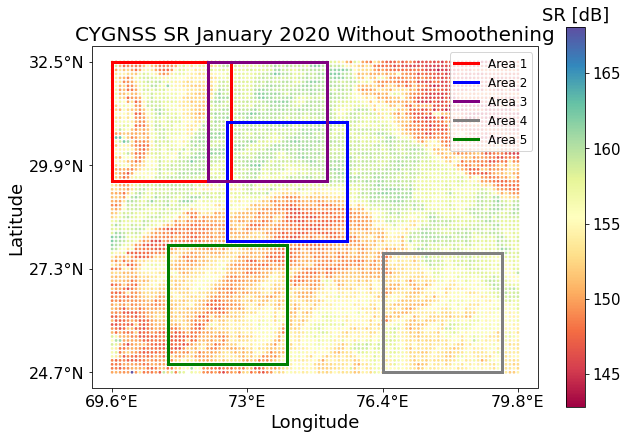

In [91]:
d_size = 2.9

area1 = {'north': 32.5, 'south': 29.5, 'west': 69.6, 'east': 72.6}
area2 = {'north': 31.0, 'south': 28.0, 'west': 72.5, 'east': 75.5}
area3 = {'north': 32.5, 'south': 29.5, 'west': 72.0, 'east': 75.0}
area4 = {'north': 27.7, 'south': 24.7, 'west': 76.4, 'east': 79.4}
area5 = {'north': 27.9, 'south': 24.9, 'west': 71.0, 'east': 74.0}

region_colors = ['red', 'blue', 'purple', 'grey', 'green']  

regions = [Rectangle((area1['west'], area1['south']), area1['east'] - area1['west'], area1['north'] - area1['south'], lw=3, fill=False, edgecolor=region_colors[0]),
           Rectangle((area2['west'], area2['south']), area2['east'] - area2['west'], area2['north'] - area2['south'], lw=3, fill=False, edgecolor=region_colors[1]),
           Rectangle((area3['west'], area3['south']), area3['east'] - area3['west'], area3['north'] - area3['south'], lw=3, fill=False, edgecolor=region_colors[2]),
           Rectangle((area4['west'], area4['south']), area4['east'] - area4['west'], area4['north'] - area4['south'], lw=3, fill=False, edgecolor=region_colors[3]),
           Rectangle((area5['west'], area5['south']), area5['east'] - area5['west'], area5['north'] - area5['south'], lw=3, fill=False, edgecolor=region_colors[4])]

area_names = ['Area 1', 'Area 2', 'Area 3', 'Area 4', 'Area 5']

universal_plot(filtering_df, target_value='sr', 
               title='CYGNSS SR January 2020 Without Smoothening', 
               bar_title='SR [dB]', 
               save=None, 
               dot_size=d_size, 
               std=False, 
               fig_size=(10, 10), 
               regions=regions,
               region_colors=region_colors,
               region_names=area_names)


Removing bad quality CYGNSS measurements...
Removed 119258 rows of bad overall quality


/var/folders/11/0v6dl9dd455c1b47f6bgcq4c0000gp/T/ipykernel_28482/4157736356.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lat'] = df['lat'].apply(lambda x: round(x, 1))
/var/folders/11/0v6dl9dd455c1b47f6bgcq4c0000gp/T/ipykernel_28482/4157736356.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['long'] = df['long'].apply(lambda x: round(x, 1))


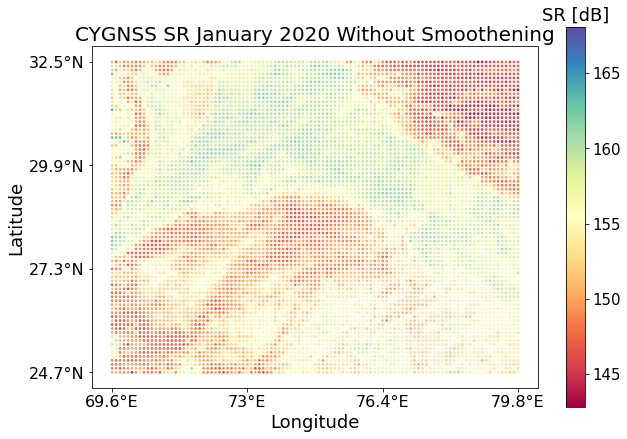

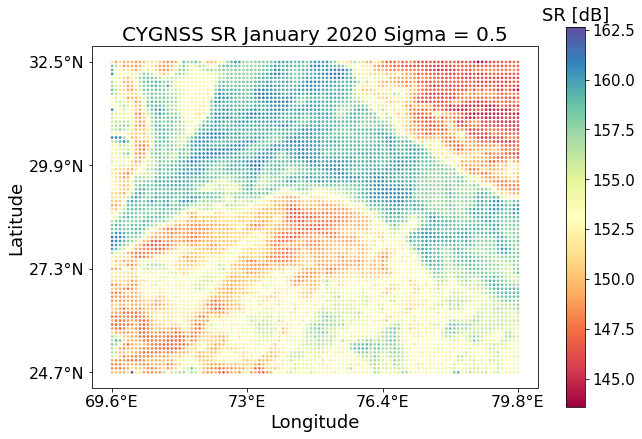

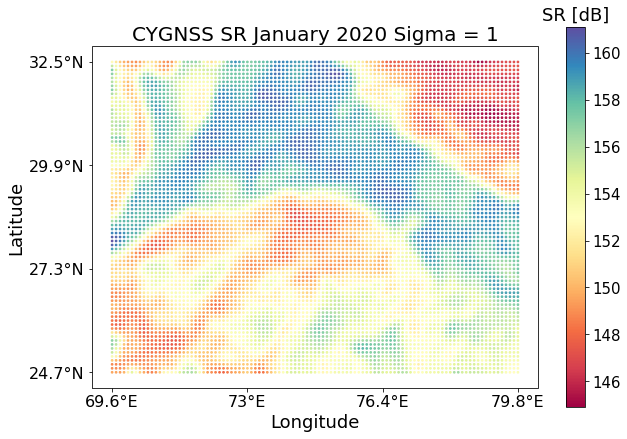

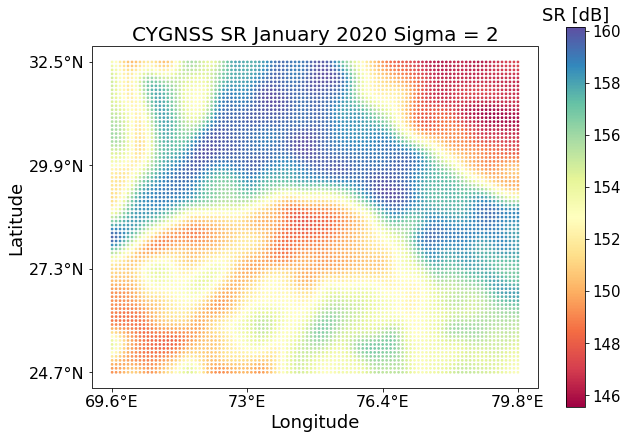

In [70]:
filtering_df = filter_quality_flags_1(cygnss_df_raw)

filtering_df = grid_box(filtering_df, 'sr', True)

d_size = 2.9

universal_plot(filtering_df, target_value='sr', 
               title='CYGNSS SR January 2020 Without Smoothening', 
               bar_title='SR [dB]', 
               save=None, 
               dot_size=d_size, 
               std=False, 
               fig_size=(10, 10), 
               regions=None)

avg_sr = filtering_df['sr'].mean()
filtering_df.loc[len(filtering_df.index)] = [71.5, 24.7, avg_sr] 


universal_plot(smoothening(filtering_df, selected_area, 0.5, 'sr'), target_value='sr', 
               title='CYGNSS SR January 2020 Sigma = 0.5', 
               bar_title='SR [dB]', 
               save=None, 
               dot_size=d_size, 
               std=False, 
               fig_size=(10, 10), 
               regions=None)

universal_plot(smoothening(filtering_df, selected_area, 1, 'sr'), target_value='sr', 
               title='CYGNSS SR January 2020 Sigma = 1', 
               bar_title='SR [dB]', 
               save=None, 
               dot_size=d_size, 
               std=False, 
               fig_size=(10, 10), 
               regions=None)

universal_plot(smoothening(filtering_df, selected_area, 2, 'sr'), target_value='sr', 
               title='CYGNSS SR January 2020 Sigma = 2', 
               bar_title='SR [dB]', 
               save=None, 
               dot_size=d_size, 
               std=False, 
               fig_size=(10, 10), 
               regions=None)


In [ ]:
if qf1_removal:
    cygnss_df = filter_quality_flags_1(cygnss_df_raw)
else:
    cygnss_df = cygnss_df_raw

# Grid boxing CYGNSS
cygnss_df = grid_box(cygnss_df)
cygnss_df.head()

In [ ]:
smap_df_raw = get_smap_main(smap_root_path, year, month, days)

In [ ]:
smap_df = filter_cygnss_df(smap_df_raw, selected_area)
smap_df = grid_box(smap_df, 'smap_sm', False)

In [ ]:
universal_plot(cygnss_df, 'sr',
              title='CYGNSS Jan 2020',
              bar_title='SR [dB]',
              dot_size=8)

universal_plot(smap_df, 'smap_sm',
              title='SMAP Jan 2020',
              bar_title='SM [cm^3/cm^3]',
              dot_size=8)
    

In [69]:
area1 = {'north': 32.5, 'south': 29.5, 'west': 69.6, 'east': 72.6}
area2 = {'north': 31.0, 'south': 28.0, 'west': 72.5, 'east': 75.5}
area3 = {'north': 32.5, 'south': 29.5, 'west': 72.0, 'east': 75.0}
area4 = {'north': 27.7, 'south': 24.7, 'west': 76.4, 'east': 79.4}
area5 = {'north': 27.9, 'south': 24.9, 'west': 71.0, 'east': 74.0}

smoothening_areas = [area1, area2, area3, area4, area5]
smooth_lists = []
for a in smoothening_areas:
    current_cyg = filter_cygnss_df(cygnss_df, a)
    current_smap = filter_cygnss_df(smap_df, a)
    
    smooth_list = smoothening_analysis(current_cyg, current_smap, a, 0, 20, use_plot=False)
    smooth_lists.append(smooth_list)


NameError: name 'cygnss_df' is not defined

In [ ]:
fig = plt.figure(figsize=(12, 7))
ax = plt.axes()

i = 1
for smooth_list in smooth_lists:
    ax.plot(smooth_list.keys(), smooth_list.values(), linewidth=3, label='Area ' + str(i))
    i = i + 1
plt.title('Smoothening Analysis', fontsize=20)
plt.xlabel('Sigma', fontsize=14)
plt.ylabel('Correlation Coefficient', fontsize=14)
plt.legend(fontsize='large', loc='center right')
plt.savefig('/Users/vegardhaneberg/Desktop/Plots Master/Smoothening/main_smoothening.png', )
plt.show()

In [68]:
area_name = 'Area 5'
area5 = {'north': 27.9, 'south': 24.9, 'west': 71.0, 'east': 74.0}
analysed_area = area5
best_sigma = 13.2

save_path = '/Users/vegardhaneberg/Desktop/Plots Master/Smoothening/Best Sigma Plots/' + area_name + '/'
universal_plot(filter_cygnss_df(cygnss_df, analysed_area), 'sr',
              title='CYGNSS ' + area_name + ' without Smoothening',
              bar_title='SM [dB]',
              dot_size=38,
              save= save_path + area_name + ' Without Smoothening')

universal_plot(smoothening(filter_cygnss_df(cygnss_df, analysed_area), analysed_area, best_sigma, 'sr'), 'sr',
              title='CYGNSS ' + area_name + ' with Sigma = ' + str(best_sigma),
              bar_title='SR [db]',
              dot_size=38,
              save=save_path + area_name + ' With Smoothening')

universal_plot(filter_cygnss_df(smap_df, analysed_area), 'smap_sm',
              title='SMAP ' + area_name,
              bar_title='SM [cm^3/cm^3]',
              dot_size=38,
              save=save_path + area_name + ' SMAP')

NameError: name 'area5' is not defined

In [ ]:
################################################
########## MAIN SMOOTHENING ANALYSIS ##########
################################################

# Areas
africa = {'north': -7, 'south': -12, 'west': 23, 'east': 28}
brazil = {'north': -5, 'south': -10, 'west': -42, 'east': -37}
australia = {'north': -22, 'south': -27, 'west': 117, 'east': 122}
iran = {'north': 31, 'south': 26, 'west': 59, 'east': 64}
india = {'north': 24, 'south': 19, 'west': 80, 'east': 85}

year = 2020
month = 1
start_day = 1
end_day = 31
days = list(range(start_day, end_day + 1))
angle_interval = [0, 60]

qf1_removal = True

# CYGNSS paths
cygnss_africa_path = '/Volumes/Seagate Ekstern Hardisk/Processed Files/-7-23--12-28/CYGNSS2020-withQFs-[-7-23--12-28].csv'
cygnss_brazil_path = '/Volumes/Seagate Ekstern Hardisk/Processed Files/-5--42--10--37/CYGNSS2020-withQFs-[-5--42--10--37].csv'
cygnss_australia_path = '/Volumes/Seagate Ekstern Hardisk/Processed Files/-22-117--27-122/CYGNSS2020-withQFs-[-22-117--27-122].csv'
cygnss_iran_path = '/Volumes/Seagate Ekstern Hardisk/Processed Files/31-59-26-64/CYGNSS2020-withQFs-[31-59-26-64].csv'
cygnss_india_path = '/Volumes/Seagate Ekstern Hardisk/Processed Files/24-80-19-85/CYGNSS2020-withQFs-[24-80-19-85].csv'

# SMAP Paths
smap_africa_path = '/Users/vegardhaneberg/Desktop/Masters Thesis/Code/Master/Data/SMAP/9km/Jan 2020 Africa'
smap_brazil_path = '/Users/vegardhaneberg/Desktop/Masters Thesis/Code/Master/Data/SMAP/9km/Jan 2020 Brazil'
smap_australia_path = '/Users/vegardhaneberg/Desktop/Masters Thesis/Code/Master/Data/SMAP/9km/Jan 2020 Australia'
smap_iran_path = '/Users/vegardhaneberg/Desktop/Masters Thesis/Code/Master/Data/SMAP/9km/Jan 2020 Iran'
smap_india_path = '/Users/vegardhaneberg/Desktop/Masters Thesis/Code/Master/Data/SMAP/9km/Jan 2020 India'

areas = [africa, brazil, australia, iran, india]
cygnss_paths = [cygnss_africa_path, cygnss_brazil_path, cygnss_australia_path, cygnss_iran_path, cygnss_india_path]
smap_paths = [smap_africa_path, smap_brazil_path, smap_australia_path, smap_iran_path, smap_india_path]





In [ ]:
# Africa

africa_df = pd.read_csv(cygnss_africa_path).rename(columns={'sp_lat': 'lat', 'sp_lon': 'long'})
current_cygnss_df = filter_quality_flags_1(africa_df, False)
africa_df_grid_boxed = grid_box(africa_df)
universal_plot(africa_df_grid_boxed, 'sr', 
               title='CYGNSS SR Africa Jan 2020', 
               bar_title='SR [dB]', 
               save=None, 
               dot_size=25)

africa_smap_df = get_smap_main(smap_africa_path, year, month, days)
africa_smap_df_grid_boxed = grid_box(africa_smap_df, 'smap_sm', False)
universal_plot(africa_smap_df_grid_boxed, 'smap_sm', 
               title='SMAP SM Africa Jan 2020', 
               bar_title='SM [cm^3/cm^3]', 
               save=None, 
               dot_size=15)

smoothening_analysis(africa_df_grid_boxed, africa_smap_df_grid_boxed, africa, start_sig=0, end_sig=10, interval=0.1, save=None)
print('done')


In [ ]:
test = grid_box(africa_smap_df, 'smap_sm', True)
universal_plot(test, 'smap_sm', 
               title='SMAP SM Africa Jan 2020', 
               bar_title='SM [cm^3/cm^3]', 
               save=None, 
               dot_size=15)

In [ ]:
raw_brazil_df = pd.read_csv(cygnss_brazil_path).rename(columns={'sp_lat': 'lat', 'sp_lon': 'long'})
# raw_brazil_smap_df = get_smap_main(smap_brazil_path, year, month, days)
raw_brazil_smap_df = brazil_smap_df

In [ ]:
# Brazil
test_brazil = {'north': -5, 'south': -8, 'west': -42, 'east': -39}

# brazil_df = pd.read_csv(cygnss_brazil_path).rename(columns={'sp_lat': 'lat', 'sp_lon': 'long'})
brazil_df = raw_brazil_df
brazil_df = filter_cygnss_df(brazil_df, test_brazil)
brazil_df = filter_quality_flags_1(brazil_df, False)
brazil_df_grid_boxed = grid_box(brazil_df)
universal_plot(brazil_df_grid_boxed, 'sr', 
               title='CYGNSS SR Brazil Jan 2020', 
               bar_title='SR [dB]', 
               save=None, 
               dot_size=45)

# brazil_smap_df = get_smap_main(smap_brazil_path, year, month, days)
brazil_smap_df = raw_brazil_smap_df
brazil_smap_df = filter_cygnss_df(brazil_smap_df, test_brazil)
brazil_smap_df_grid_boxed = grid_box(brazil_smap_df, 'smap_sm', False)
universal_plot(brazil_smap_df_grid_boxed, 'smap_sm', 
               title='SMAP SM Brazil Jan 2020', 
               bar_title='SM [cm^3/cm^3]', 
               save=None, 
               dot_size=45)

smothening_list = smoothening_analysis(brazil_df_grid_boxed, brazil_smap_df_grid_boxed, test_brazil, start_sig=0, end_sig=10, interval=0.1, save=None)
print('done')


In [ ]:
print(max(np.abs(list(smothening_list.values()))))
min_index = list(smothening_list.values()).index(min(list(smothening_list.values())))
print(list(smothening_list.keys())[min_index])

In [ ]:
dicts_with_smoothening_data = []

for i in range(len(areas)):
    current_area = areas[i]
    current_cygnss_path = cygnss_paths[i]
    current_smap_path = smap_paths[i]
    
    current_cygnss_df = pd.read_csv(current_cygnss_path).rename(columns={'sp_lat': 'lat', 'sp_lon': 'long'})
    if qf1_removal:
        current_cygnss_df = filter_quality_flags_1(current_cygnss_df, False)
    current_cygnss_df = grid_box(current_cygnss_df)
        
    current_smap_df = get_smap_main(current_smap_path, year, month, days)
    
    current_smap_df = grid_box(current_smap_df, 'smap_sm', False)
    
    smoothening_list = smoothening_analysis(current_cygnss_df, current_smap_df, current_area, start_sig=0, end_sig=10, interval=0.1, save=None)
    
    dicts_with_smoothening_data.append(smoothening_list)
    
    
label_names = ['Africa', 'Brazil', 'Australia', 'Iran', 'India']

fig = plt.figure(figsize=(15, 6))

for i in range(len(dicts_with_smoothening_data)):
    plt.plot(list(dicts_with_smoothening_data[i].keys()), list(dicts_with_smoothening_data[i].values()), label=label_names[i])
plt.title('Correlation between CYGNSS and SMAP', fontsize=18)
plt.ylabel('Correlation Coefficient', fontsize=12)
plt.xlabel('Sigma', fontsize=12)

plt.legend(fontsize='small')
plt.savefig('/Users/vegardhaneberg/Desktop/Plots Master/Smoothening/main_smoothening.png', bbox_inches='tight')
plt.show()





In [7]:
# CYGNSS Variables
last_semester_area = {'north': 32.5, 'south': 24.7, 'west': 69.6, 'east': 79.8}
africa = {'north': -7, 'south': -12, 'west': 23, 'east': 28}
brazil = {'north': -5, 'south': -10, 'west': -42, 'east': -37}
australia = {'north': -22, 'south': -27, 'west': 117, 'east': 122}
iran = {'north': 31, 'south': 26, 'west': 59, 'east': 64}
india = {'north': 24, 'south': 19, 'west': 80, 'east': 85}

selected_area = last_semester_area

cygnss_root_path = '/Volumes/Seagate Ekstern Hardisk/CYGNSS Data/CYGNSS 2020-01'
year = 2020
month = 1
start_day = 1
end_day = 31
days = list(range(start_day, end_day + 1))
angle_interval = [0, 60]

qf1_removal = True

# SMAP Variables
smap_root_path = '/Users/vegardhaneberg/Desktop/Masters Thesis/Code/Master/Data/SMAP/9km/Jan 2020 area1'

# Start reading CYGNSS
cygnss_df = get_cygnss_df(cygnss_root_path, days, month, selected_area, angle_interval)

if qf1_removal:
    cygnss_df = filter_quality_flags_1(cygnss_df)

# Grid boxing CYGNSS
cygnss_df = grid_box(cygnss_df)

100%|██████████| 31/31 [07:34<00:00, 14.65s/it]


Removing bad quality CYGNSS measurements...
Removed 119258 rows of bad overall quality


In [8]:

missing_coord = (24.7, 71.5)
inter_func = interpolate(cygnss_df, 'sr')

cygnss_df = cygnss_df.append({'long': float(71.5), 'lat': float(24.7), 'sr': float(inter_func(24.7, 71.5))}, ignore_index=True)
cygnss_df['sr'] = pd.to_numeric(cygnss_df['sr'])
print(cygnss_df.dtypes)  # All should be float64


long    float64
lat     float64
sr      float64
dtype: object


In [ ]:
"""

def smoothening_with_nan(df: pd.DataFrame, area: dict, sigma: float, target_value='sr') -> pd.DataFrame:
    lats = np.arange(area['north'], area['south'] - 0.05, -0.1)
    lats = [round(num, 1) for num in lats]
    lats_length = len(lats)
    longs = np.arange(area['west'], area['east'] + 0.05, 0.1)
    longs = [round(num, 1) for num in longs]
    longs_length = len(longs)

    lats, longs = np.meshgrid(lats, longs, indexing='ij')
    lats = lats.flatten()
    longs = longs.flatten()
    ideal_df = pd.DataFrame.from_dict({'lat': lats, 'long': longs})

    df_merged = pd.merge(ideal_df, df, left_on=['lat', 'long'], right_on=['lat', 'long'], how='left')
    df_merged = df_merged.sort_values(['lat', 'long'], ascending=(False, True))
    
    target_values = np.array(df_merged[target_value]).reshape(lats_length, longs_length)
    
    target_values = convolve(target_values, Gaussian2DKernel(x_stddev=sigma, y_stddev=sigma, x_size=7, y_size=7))
    
    ideal_df['smooth_sr'] = target_values.flatten()
    return ideal_df
    
    target_values = target_values.flatten()
    df[target_value + '_' + str(sigma)] = target_values
    
    return df

smooth_1 = smoothening_with_nan(cygnss_df, selected_area, 1, 'sr')

universal_plot(smooth_1, 'smooth_sr', title='CYGNSS SR', bar_title='SR [dB]', save=False, dot_size=4)

smooth_1 = filter_cygnss_df(smooth_1, selected_area)

universal_plot(smooth_1, 'smooth_sr', title='CYGNSS SR', bar_title='SR [dB]', save=False, dot_size=4)
"""

100% (31 of 31) |########################| Elapsed Time: 0:13:05 Time:  0:13:05


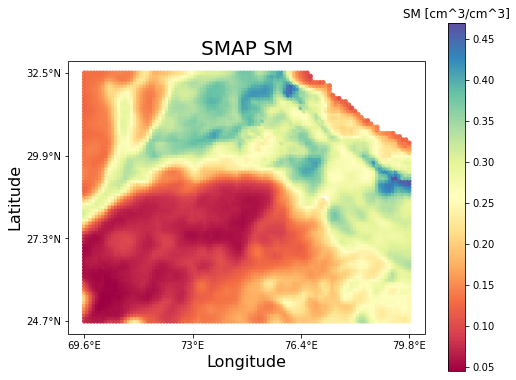

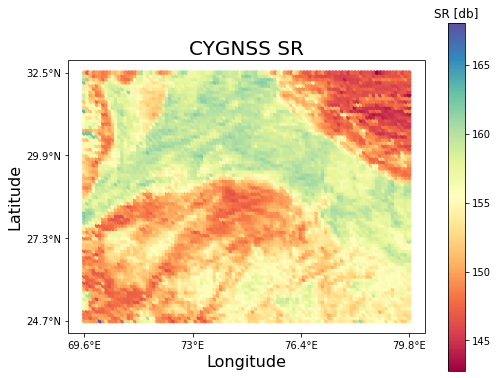

In [9]:
# Reading SMAP  
smap_root_path = '/Users/vegardhaneberg/Desktop/Masters Thesis/Code/Master/Data/SMAP/9km/Semester Project Area/Jan 2020'
smap_df = get_smap_main(smap_root_path, year, month, days)

# Grid boxing SMAP
smap_df = grid_box(smap_df, 'smap_sm', False)
smap_df.head()

# Plot grid boxed SMAP and CYGNSS
universal_plot(smap_df, 'smap_sm', 
               title='SMAP SM', 
               bar_title='SM [cm^3/cm^3]', 
               save=None, 
               dot_size=15)

universal_plot(cygnss_df, 'sr', 
               title='CYGNSS SR', 
               bar_title='SR [db]', 
               save=None, 
               dot_size=15)

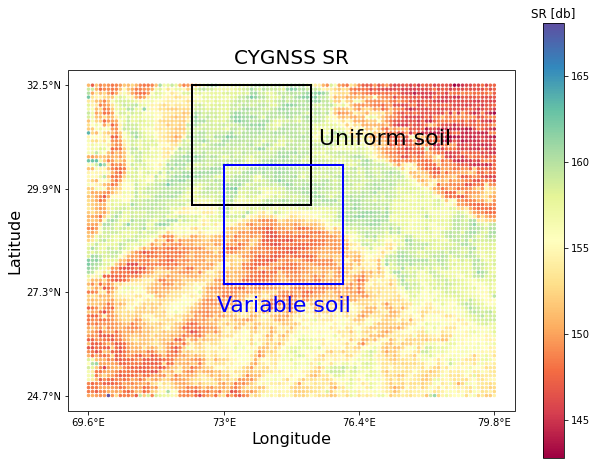

In [10]:
region_same = RectanglePixelRegion(center=PixCoord(x=73.7, y=31), width=3, height=3)
region_diff = RectanglePixelRegion(center=PixCoord(x=74.5, y=29), width=3, height=3)

universal_plot(cygnss_df, 'sr', 
               title='CYGNSS SR', 
               bar_title='SR [db]',
               fig_size=(10,10),
               save='/Users/vegardhaneberg/Desktop/Test Plots/Areas variable soil analysis', 
               dot_size=6,
               regions=[region_same, region_diff])

In [ ]:
# TODO:
# Legge til vmin og vmax i soil moisture plotsa så man lettere ser at det er jevnere i same cyg plot

# Lage et plot som viser hvilke områder som er brukt.

# Kjøre all kode og lage en tabell med resultatene som kan skrives om

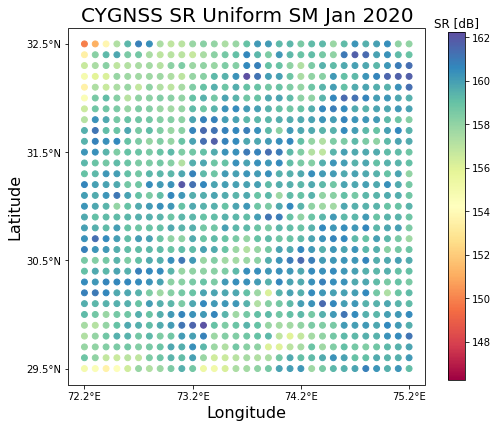

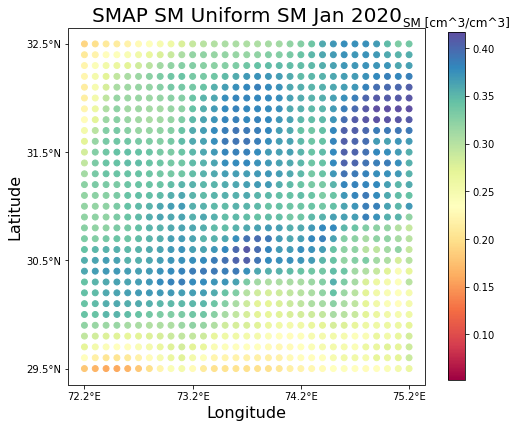

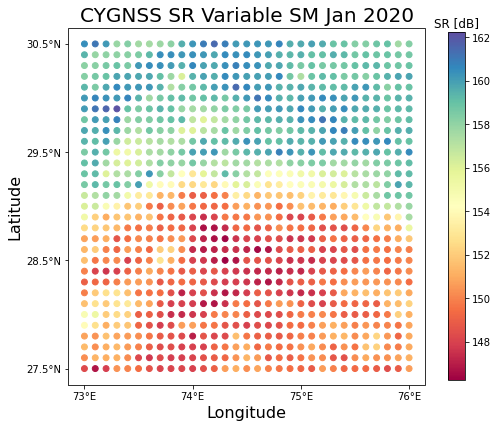

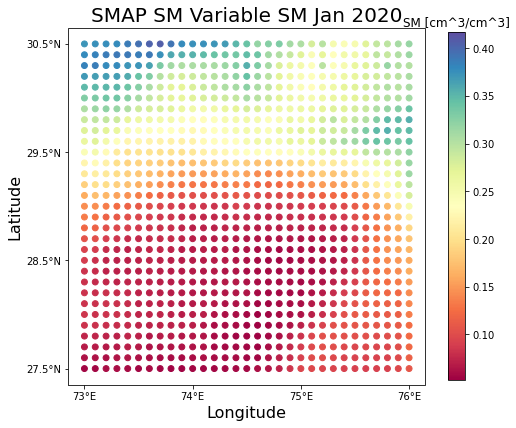

0.45323053779467587
0.9240727685945428


In [11]:
# Analysis before the meeting with Mostafa
same_soil_type_area = {'north': 32.5, 'south': 29.5, 'west': 72.2, 'east': 75.2}
diff_soil_type_area = {'north': 30.5, 'south': 27.5, 'west': 73, 'east': 76}

same_cyg_df_jan = filter_cygnss_df(cygnss_df, same_soil_type_area)
diff_cyg_df_jan = filter_cygnss_df(cygnss_df, diff_soil_type_area)

same_smap_df_jan = filter_cygnss_df(smap_df, same_soil_type_area)
diff_smap_df_jan = filter_cygnss_df(smap_df, diff_soil_type_area)

vmin_cygnss = min(same_cyg_df_jan['sr'].min(), diff_cyg_df_jan['sr'].min())
vmax_cygnss = max(same_cyg_df_jan['sr'].max(), diff_cyg_df_jan['sr'].max())

vmin_smap = min(same_smap_df_jan['smap_sm'].min(), diff_smap_df_jan['smap_sm'].min())
vmax_smap = max(same_smap_df_jan['smap_sm'].max(), diff_smap_df_jan['smap_sm'].max())

universal_plot(same_cyg_df_jan, 
               'sr', 
               title='CYGNSS SR Uniform SM Jan 2020', 
               bar_title='SR [dB]', 
               save='/Users/vegardhaneberg/Desktop/Test Plots/same SM cygnss jan',
               vmin=vmin_cygnss,
               vmax=vmax_cygnss,
               dot_size=35)

universal_plot(same_smap_df_jan, 
               'smap_sm', 
               title='SMAP SM Uniform SM Jan 2020', 
               bar_title='SM [cm^3/cm^3]', 
               save='/Users/vegardhaneberg/Desktop/Test Plots/same SM smap jan', 
               vmin=vmin_smap,
               vmax=vmax_smap,
               dot_size=35)

universal_plot(diff_cyg_df_jan, 
               'sr', 
               title='CYGNSS SR Variable SM Jan 2020', 
               bar_title='SR [dB]', 
               save='/Users/vegardhaneberg/Desktop/Test Plots/diff SM cygnss jan',
               vmin=vmin_cygnss,
               vmax=vmax_cygnss,
               dot_size=35)

universal_plot(diff_smap_df_jan, 
               'smap_sm', 
               title='SMAP SM Variable SM Jan 2020', 
               bar_title='SM [cm^3/cm^3]', 
               save='/Users/vegardhaneberg/Desktop/Test Plots/diff SM smap jan',
               vmin=vmin_smap,
               vmax=vmax_smap,
               dot_size=35)

merged_same_soil_df_jan = pd.merge(same_cyg_df_jan, same_smap_df_jan, on=['lat', 'long'], how='inner')
merged_diff_soil_df_jan = pd.merge(diff_cyg_df_jan, diff_smap_df_jan, on=['lat', 'long'], how='inner')

print(merged_same_soil_df_jan['smap_sm'].corr(merged_same_soil_df_jan['sr']))
print(merged_diff_soil_df_jan['smap_sm'].corr(merged_diff_soil_df_jan['sr']))

In [12]:
###########################################
#### Same analysis with CYGNSS August #####
###########################################

year_aug = 2020
month_aug = 8
start_day = 1
end_day = 31
days_aug = list(range(start_day, end_day + 1))
angle_interval = [0, 60]

#Read CYGNSS
cygnss_august_2020_root_path = '/Volumes/Seagate Ekstern Hardisk/CYGNSS Data/CYGNSS 2020-08'
cygnss_df_aug = get_cygnss_df(cygnss_august_2020_root_path, days_aug, month_aug, selected_area, angle_interval)

cygnss_df_aug.head()

# Filter bad quality values
if qf1_removal:
    cygnss_df_aug = filter_quality_flags_1(cygnss_df_aug)

# Grid box CYGNSS
cygnss_df_aug = grid_box(cygnss_df_aug)

100%|██████████| 31/31 [07:43<00:00, 14.97s/it]


Removing bad quality CYGNSS measurements...
Removed 114448 rows of bad overall quality


In [13]:
###########################################
##### Same analysis with SMAP August ######
###########################################

# Read SMAP
smap_root_path_aug = '/Users/vegardhaneberg/Desktop/Masters Thesis/Code/Master/Data/SMAP/9km/Semester Project Area/Aug 2020/'
smap_df_aug = get_smap_main(smap_root_path_aug, year_aug, month_aug, days_aug)

# Grid box SMAP
smap_df_aug = grid_box(smap_df_aug, 'smap_sm')


100% (31 of 31) |########################| Elapsed Time: 0:11:54 Time:  0:11:54


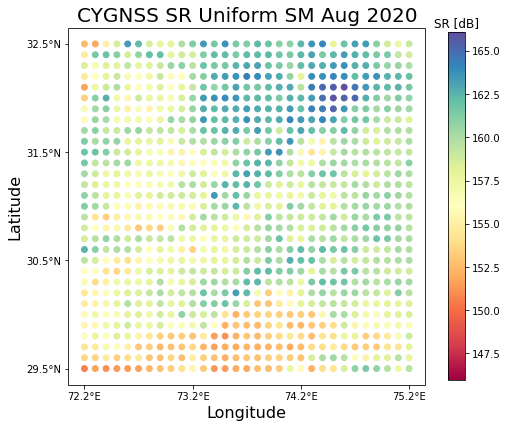

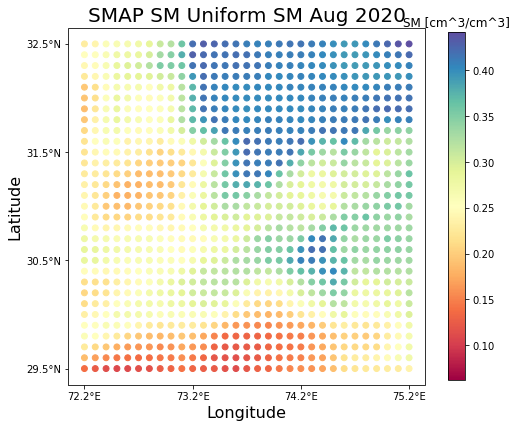

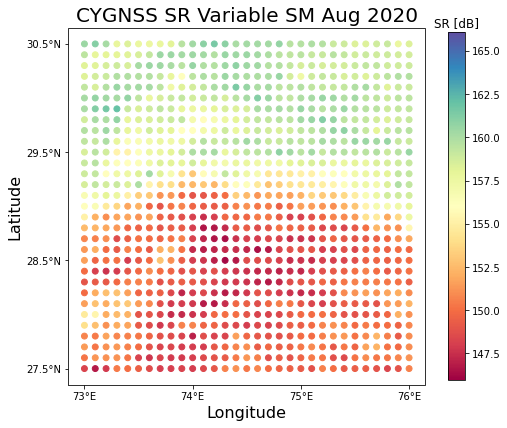

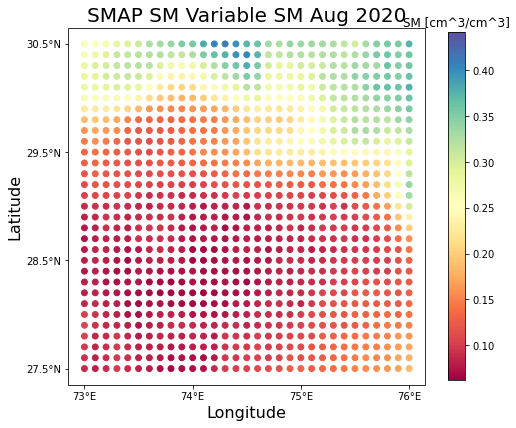

In [14]:
same_cyg_df_aug = filter_cygnss_df(cygnss_df_aug, same_soil_type_area)
diff_cyg_df_aug = filter_cygnss_df(cygnss_df_aug, diff_soil_type_area)


same_smap_df_aug = filter_cygnss_df(smap_df_aug, same_soil_type_area)
diff_smap_df_aug = filter_cygnss_df(smap_df_aug, diff_soil_type_area)

vmin_cygnss = min(same_cyg_df_aug['sr'].min(), diff_cyg_df_aug['sr'].min())
vmax_cygnss = max(same_cyg_df_aug['sr'].max(), diff_cyg_df_aug['sr'].max())

vmin_smap = min(same_smap_df_aug['smap_sm'].min(), diff_smap_df_aug['smap_sm'].min())
vmax_smap = max(same_smap_df_aug['smap_sm'].max(), diff_smap_df_aug['smap_sm'].max())

universal_plot(same_cyg_df_aug, 
               'sr', 
               title='CYGNSS SR Uniform SM Aug 2020', 
               bar_title='SR [dB]', 
               save='/Users/vegardhaneberg/Desktop/Test Plots/same SM cygnss aug',
               vmin=vmin_cygnss,
               vmax=vmax_cygnss,
               dot_size=35)

universal_plot(same_smap_df_aug, 
               'smap_sm', 
               title='SMAP SM Uniform SM Aug 2020', 
               bar_title='SM [cm^3/cm^3]', 
               save='/Users/vegardhaneberg/Desktop/Test Plots/same SM smap aug',
               vmin=vmin_smap,
               vmax=vmax_smap,
               dot_size=35)

universal_plot(diff_cyg_df_jan, 
               'sr', 
               title='CYGNSS SR Variable SM Aug 2020', 
               bar_title='SR [dB]', 
               save='/Users/vegardhaneberg/Desktop/Test Plots/diff SM cygnss aug', 
               vmin=vmin_cygnss,
               vmax=vmax_cygnss,
               dot_size=35)

universal_plot(diff_smap_df_aug, 
               'smap_sm', 
               title='SMAP SM Variable SM Aug 2020', 
               bar_title='SM [cm^3/cm^3]', 
               save='/Users/vegardhaneberg/Desktop/Test Plots/diff SM smap aug',
               vmin=vmin_smap,
               vmax=vmax_smap,
               dot_size=35)



In [15]:
merged_same_soil_df_aug = pd.merge(same_cyg_df_aug, same_smap_df_aug, on=['lat', 'long'], how='inner')
merged_diff_soil_df_aug = pd.merge(diff_cyg_df_aug, diff_smap_df_aug, on=['lat', 'long'], how='inner')

print(merged_same_soil_df_aug['smap_sm'].corr(merged_same_soil_df_aug['sr']))
print(merged_diff_soil_df_aug['smap_sm'].corr(merged_diff_soil_df_aug['sr']))

0.8125295172634088
0.914234533822002


In [ ]:
smoothening_analysis(same_cyg_df_aug, same_smap_df_aug, same_soil_type_area)

In [ ]:
smoothening_analysis(diff_cyg_df_aug, diff_smap_df_aug, diff_soil_type_area)

In [16]:
####################################
### Temporal difference analysis ###
####################################


same_cyg_df_merged = pd.merge(same_cyg_df_aug.rename(columns={'sr': 'sr_aug'}), same_cyg_df_jan.rename(columns={'sr': 'sr_jan'}), on=['lat', 'long'], how='inner')
diff_cyg_df_merged = pd.merge(diff_cyg_df_aug.rename(columns={'sr': 'sr_aug'}), diff_cyg_df_jan.rename(columns={'sr': 'sr_jan'}), on=['lat', 'long'], how='inner')

same_smap_df_merged = pd.merge(same_smap_df_aug.rename(columns={'smap_sm': 'smap_sm_aug'}), same_smap_df_jan.rename(columns={'smap_sm': 'smap_sm_jan'}), on=['lat', 'long'], how='inner')
diff_smap_df_merged = pd.merge(diff_smap_df_aug.rename(columns={'smap_sm': 'smap_sm_aug'}), diff_smap_df_jan.rename(columns={'smap_sm': 'smap_sm_jan'}), on=['lat', 'long'], how='inner')

#------------------------------------------------------------------------------------------------------------------

same_cyg_df_merged['sr_diff'] = same_cyg_df_merged['sr_jan'] - same_cyg_df_merged['sr_aug']
diff_cyg_df_merged['sr_diff'] = diff_cyg_df_merged['sr_jan'] - diff_cyg_df_merged['sr_aug']

same_smap_df_merged['smap_sm_diff'] = same_smap_df_merged['smap_sm_jan'] - same_smap_df_merged['smap_sm_aug']
diff_smap_df_merged['smap_sm_diff'] = diff_smap_df_merged['smap_sm_jan'] - diff_smap_df_merged['smap_sm_aug']

#------------------------------------------------------------------------------------------------------------------

same_temporal_merged = pd.merge(same_cyg_df_merged, same_smap_df_merged, on=['lat', 'long'], how='inner')
diff_temporal_merged = pd.merge(diff_cyg_df_merged, diff_smap_df_merged, on=['lat', 'long'], how='inner')


In [17]:
print(same_temporal_merged['smap_sm_diff'].corr(same_temporal_merged['sr_diff']))
print(diff_temporal_merged['smap_sm_diff'].corr(diff_temporal_merged['sr_diff']))

0.6732676137307135
0.6368793282506641


In [ ]:
smoothening_analysis(same_cyg_df_merged.rename(columns={'sr_diff': 'sr'}), same_smap_df_merged.rename(columns={'smap_sm_diff': 'smap_sm'}), diff_soil_type_area)


In [ ]:
smoothening_analysis(diff_cyg_df_merged.rename(columns={'sr_diff': 'sr'}), diff_smap_df_merged.rename(columns={'smap_sm_diff': 'smap_sm'}), diff_soil_type_area)
